In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

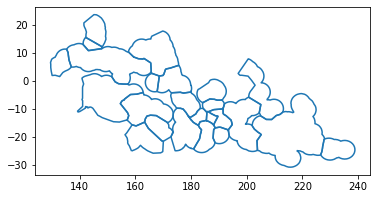

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
date = 'this month'

In [11]:
year = dateparser.parse(date).year

In [12]:
month = dateparser.parse(date).month

In [13]:
print(f"{year} - {month}")

2021 - 11


### read the probabilistic forecasts from the GCMs now 

### provider 

In [14]:
provider = 'CDS'

#### list of GCMs to inlude 

In [15]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

#### period (`monthly` or `seasonal`)

In [16]:
# period = 'monthly'
period = 'seasonal'

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [18]:
quantile = 'percentile'

### variable 

In [19]:
varname = 'precip'

### domain 

In [20]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -35, 25]}

In [21]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [22]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [23]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [24]:
period

'seasonal'

In [25]:
[f.name for f in lfiles]

['seasonal_percentiles_probabilities_from_2021-11_UKMO.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_JMA.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_ECMWF.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_ECCC_CanCM4i.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_ECCC_GEM_NEMO.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_METEO_FRANCE.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_NCEP.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_DWD.netcdf',
 'seasonal_percentiles_probabilities_from_2021-11_CMCC.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [26]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

### interpolate

In [27]:
probs = utils.interp(probs, interp_factor=6)

### look at the sum for each GCM, should sum to 100 

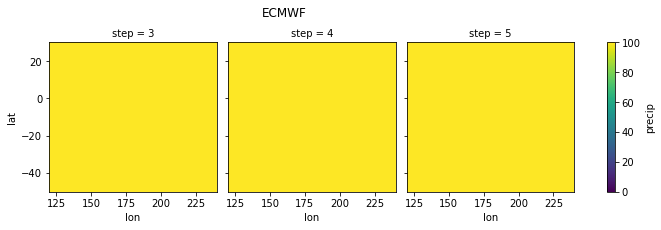

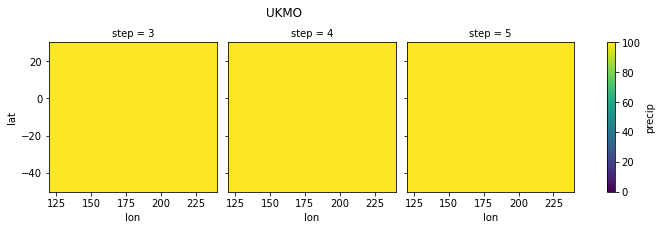

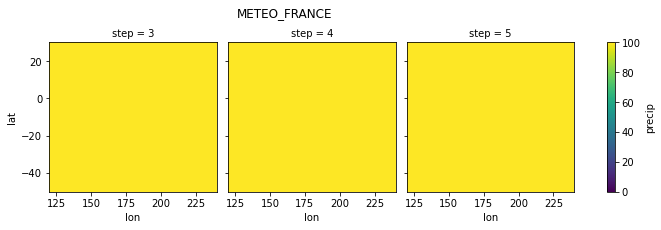

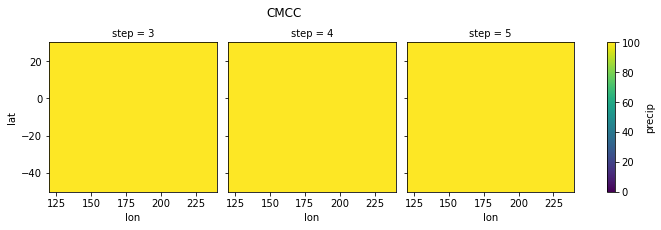

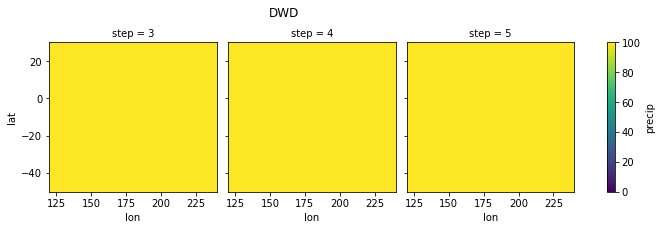

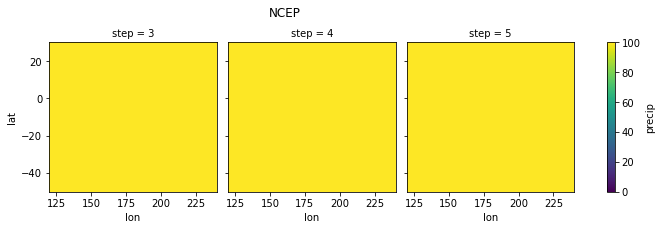

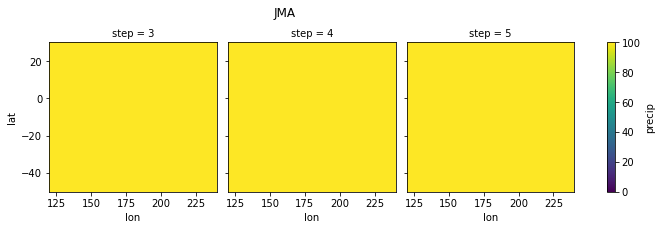

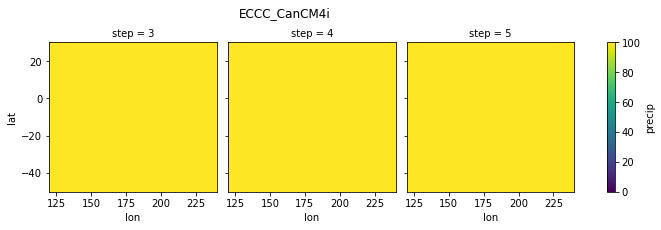

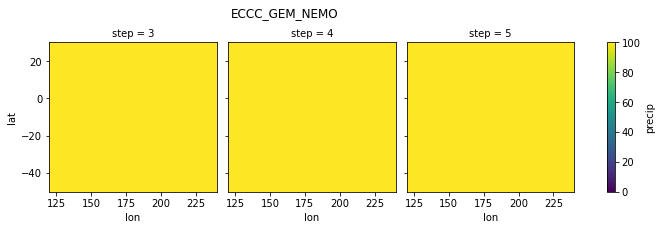

In [28]:
for GCM in list_GCMs:
    fg = probs.sel(GCM=GCM).sum(quantile).squeeze()[varname].plot(col='step', vmin=0);
    fg.fig.suptitle(GCM, x=0.4, horizontalalignment='center',y=1.05)

### calculates the average across the GCM dimension 

In [29]:
probs_mean = probs.mean('GCM')

### saves to disk ?

In [30]:
probs_mean.to_netcdf(f'./C3S_MME_prob_mean_{year}_{month:02d}.nc')

### because of numerical approximations, this average can **SOMETIMES** sum to slightly over 100 (the errors can accumulate over all the dimensions)

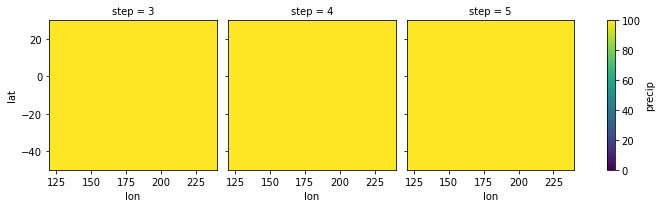

In [31]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale (just in case)

In [32]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

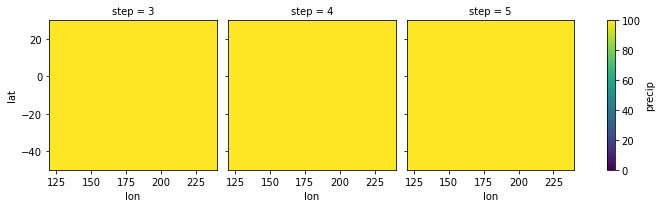

In [33]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### because the attributes are lost during these operations, we add them back 

In [34]:
probs_mean.attrs = probs.attrs

In [35]:
probs_mean.attrs

{'pct_values': array([0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

#### also adds an attribute that tells the period 

In [36]:
probs_mean.attrs['period'] = period

### Probability for being below a given percentile

#### choose the percentile here 

In [37]:
pmax = 25

### get the percentile bins edges, and select the category (starting at 1) that corresponds to the bin with right edge at `pmax`

In [38]:
print(" | ".join(map(str, probs_mean.attrs['pct_values'].tolist()))) 

0.02 | 0.05 | 0.1 | 0.15 | 0.2 | 0.25 | 0.3 | 0.35 | 0.4 | 0.45 | 0.5 | 0.55 | 0.6 | 0.65 | 0.7 | 0.75 | 0.8 | 0.85 | 0.9 | 0.95


In [39]:
max_cat = np.digitize(pmax/100, probs_mean.attrs['pct_values'])

In [40]:
max_cat

6

In [41]:
probs_mean.percentile

<xarray.DataArray 'percentile' (percentile: 21)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])
Coordinates:
    month       int64 11
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21

### plots the probabilities 

In [42]:
cmap = palettable.scientific.sequential.Bilbao_20.mpl_colormap

In [43]:
domain = domains.domains['Water_Watch']

### quick plot 

In [44]:
probs_mean.sel({quantile:slice(None, max_cat)})

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 6, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-01
  * step        (step) int64 3 4 5
    month       int64 11
  * percentile  (percentile) int64 1 2 3 4 5 6
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(6, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

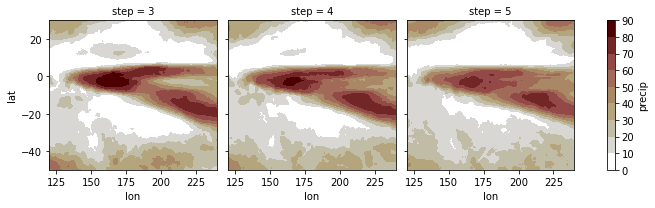

In [45]:
_ = probs_mean.sel({quantile:slice(None, max_cat)}).sum(quantile)[varname].squeeze().plot.contourf(col='step', levels=10, cmap=cmap)

### plot the probabilities for rainfall being below the climatological 25th percentile, for the next 3 months period  

In [46]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 21, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-01
  * step        (step) int64 3 4 5
    month       int64 11
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

In [47]:
probs_mean

<xarray.Dataset>
Dimensions:     (time: 1, step: 3, percentile: 21, lon: 726, lat: 486)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-01
  * step        (step) int64 3 4 5
    month       int64 11
  * percentile  (percentile) int64 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21
  * lon         (lon) float64 120.0 120.2 120.3 120.5 ... 239.7 239.8 240.0
  * lat         (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.67 29.84 30.0
Data variables:
    precip      (percentile, time, step, lat, lon) float64 dask.array<chunksize=(21, 1, 3, 486, 726), meta=np.ndarray>
Attributes:
    pct_values:  [0.02 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55...
    period:      seasonal

In [48]:
period

'seasonal'

In [49]:
first_step

3

In [50]:
probs_mean.attrs

{'pct_values': array([0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 'period': 'seasonal'}

In [51]:
hexes = ['#ffffff', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a', '#543005']

In [52]:
import matplotlib

In [53]:
cmap = matplotlib.colors.ListedColormap(hexes, name='decile')

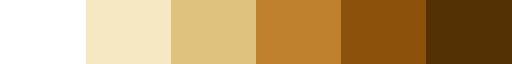

In [54]:
cmap

In [55]:
cmap  = palettable.scientific.sequential.Bilbao_6.mpl_colormap

In [56]:
cmap = plot.cmap_discretize(cmap, 6)

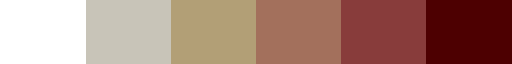

In [57]:
cmap

In [58]:
domain = [120, 240, -35, 25]

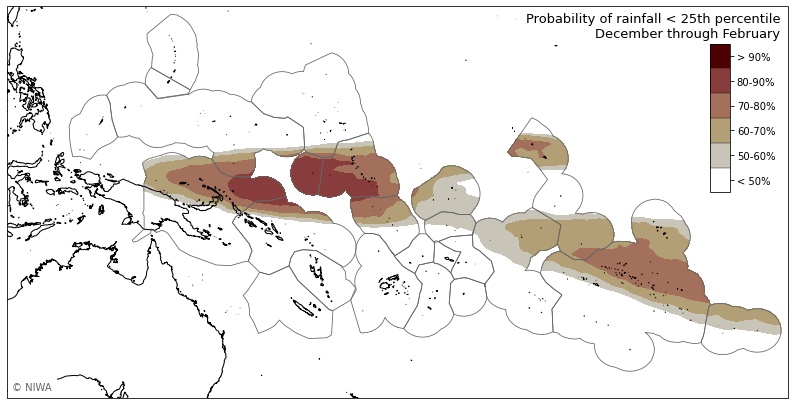

In [59]:
plot.map_MME_forecast(probs_mean, step=first_step, pct=25, mask=merged_EEZs, geoms=EEZs, fpath='/home/nicolasf/Desktop/', close=False, domain=domain)

In [60]:
period

'seasonal'